# For changes, please make a copy of this file and edit there!
------------------------
### Whenever you start with a fresh *xfel* kernel
Run the cells below **Analysis core** *first*, then the cell below **Analysis configuration**. You execute a cell by selecting it and pressing Shift+Enter.

# Analysis core
Touch with care.

In [17]:
# Initialization cell

import os
from pathlib import Path
from time import perf_counter

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.patches import Rectangle
import extra_data as xd
import extra_geom as xg
from findxfel import find_proposal

import extra_pasha as xp
xp.set_default_context('processes', num_workers=30)

from threadpoolctl import threadpool_limits
threadpool_limits(limits=1)

%matplotlib notebook
# I had problems with notebook ipywidget error, trying inline instead
%matplotlib inline
%config InlineBackend.figure_format ='retina'
#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 300

In [18]:
dark_path = "/gpfs/exfel/u/usr/SQS/202002/p002714/CalOutput/dark"
dark_path = "/gpfs/exfel/exp/SQS/202002/p002714/usr/CalOutput/dark"
os.listdir(dark_path)[0:3]

['runs_41', 'runs_70', 'runs_72']

In [179]:
def filter_hits(run_id, label, pnccd_roi=np.s_[:], trains_slice=np.s_[:], sigma=3, pnccd_cutoff=20, **xargs):
    """Filters out droplet hits from a run.
    
    Searches for hits in *trains_slice* of a given *run_id* and saves their itof
    traces and pnCCD data to a separate file with *label*. A hit is defined by
    the global callable symbol `is_hit`.
    
    Args:
        run_id (int): Run ID to process.
        label (str): Label to designate the output file.
        trains_slice (Any): Any value accepted by `DataCollection.select_trains` to
            select the trains to be analyzed.
    
    Returns:
        (array_like) Train IDs for found hits.
        (array_like) itof traces for all found hits.
        (array_like) pnCCD images for all found hits.
        (dict of array_like) Any data defined in `additional_data` 
    """
    
    # Previous manual merge of raw and proc data.
    #run = xd.RunDirectory(proposal_root / 'raw' / 'r0196') \
    #    .deselect(pnccd_source) \
    #    .union(xd.RunDirectory(proposal_root / 'scratch' / 'proc' / 'r0196_take1')) \
    #    .select_trains(trains_slice) \
    #    .select([(itof_source, itof_key), (pnccd_source, pnccd_key)] + list(additional_data.values()))
    
    # Given the MDC appears to work now, open the run the proper way.
    run = xd.open_run(proposal=proposal_id, run=run_id, data='proc') \
        .select_trains(trains_slice) \
        .select([(itof_source, itof_key), (pnccd_source, pnccd_key)] + list(additional_data.values()))
    
    # Number of hits per worker.
    hit_counter = xp.array_per_worker((), dtype=int)

    # Hit's train IDs.
    hit_tids = xp.array_per_worker((int(np.ceil(len(run.train_ids) / len(hit_counter)))+1,),
                                   dtype=np.uint64)

    # Integrated intensities for pnCCD in ROI and x-ray gas monitor.
    pnccd_intensities = xp.array(len(run.train_ids), dtype=np.float64)
    xgm_intensities = xp.array(len(run.train_ids), dtype=np.float64)
    
    # Hit finding kernel.
    def find_hits(worker_id, index, train_id, data):
        try:
            itof_trace = data[itof_source][itof_key]
            pnccd_im = data[pnccd_source][pnccd_key]
            xargs = {prefix: data[source][key]
                     for prefix, (source, key)
                     in additional_data.items()}
        except (TypeError, KeyError):
            # Data may be missing for either source.
            return

        itof_trace = correct_digitizer(itof_trace.astype(np.float32))
        pnccd_im[np.isnan(pnccd_im)] = 0.0
        # 1 photon noise is < 25 adu, adds to integral for summation so throw it away!
        pnccd_im *= (pnccd_im >= pnccd_cutoff) 

        #if is_hit(itof_trace, pnccd_im, **xargs):
        #    hit_tids[worker_id][hit_counter[worker_id]] = train_id
        #    hit_counter[worker_id] += 1
            
        pnccd_intensities[index] = pnccd_im[pnccd_roi].sum() 
        xgm_intensities[index] = np.mean(xargs['xgm'][xargs['xgm']!=1])

    start = perf_counter()
    xp.map(find_hits, run)
    end = perf_counter()

    
    print(f'Finding hits with intensity {sigma} sigma greater than mean and normalized by XGM intensity, pnccd_cutoff {pnccd_cutoff}')
    all_tids = np.array(run.train_ids)
    
    #Watch out for zeros! Replace with mean to not wreck the standard deviation!!!
    pnccd_intensities[pnccd_intensities == 0 ] = np.mean(pnccd_intensities)
    xgm_intensities[xgm_intensities == 0]      = np.mean(xgm_intensities)
    
    #Must remove NaN's AND inf to avoid errors. Replace with mean to not wreck the standard deviation!!!
    pnccd_intensities[np.isfinite(pnccd_intensities)] != np.mean(pnccd_intensities)
    xgm_intensities[np.isfinite(xgm_intensities)]     != np.mean(xgm_intensities)
    
    pnccd_norm = pnccd_intensities/xgm_intensities
    pnccd_norm[np.isfinite(pnccd_norm)] != np.mean(pnccd_norm)
    
    try:
        #Discard when the FEL goes offline. Unfortunately pnccd_norm = pnccd_intensities/xgm_intensities leads to seleccting the wrong hits
        xgm_threshhold_uJ = 2000
        all_tids_xgm = all_tids[xgm_intensities > xgm_threshhold_uJ]
        hit_tids = all_tids_xgm[pnccd_norm[xgm_intensities > xgm_threshhold_uJ] > np.mean(pnccd_norm[xgm_intensities > xgm_threshhold_uJ]) + sigma*np.std(pnccd_norm[xgm_intensities > xgm_threshhold_uJ])]
    except:
        print('Warning: perhaps XGM data missing?')
        hit_tids = all_tids[pnccd_norm > np.mean(pnccd_norm) + sigma*np.std(pnccd_norm)]
        #hit_tids = all_tids[pnccd_intensities > np.mean(pnccd_intensities) + sigma*np.std(pnccd_intensities)]
    
    if len(hit_tids) <= 5:
        print(f'WARNING!!!!: Only found {hit_tids}, dropping this hit to see if outlier skews dataset')
        print(f"Initial hit_tids: {hit_tids}")
        print(f'len all_tids {len(all_tids)}, and len unique {len(np.unique(all_tids))}')
        i=0
        hit_tidsD_cnt = 0
        sigmaD = sigma
        while hit_tidsD_cnt <= 1:
            print(f'iteration {i}')
            sigmaD -= 0.2
            #all_tidsD = all_tids[all_tids != hit_tids] #new set is old set with initial hit_tids dropped. Does not work elementwise through an array?!
            #pnccd_normD = pnccd_norm[all_tids != hit_tids] # take only norms that are not hits
            all_tidsD = np.setdiff1d(all_tids, hit_tids) # drop hit_tids
            mask_tidsD = np.prod(all_tids != hit_tids[:,None], axis=0)
            pnccd_normD = pnccd_norm[mask_tidsD > 0] # take only norms in dropped set
            hit_tidsD = all_tidsD[pnccd_normD > np.mean(pnccd_normD) + sigmaD*np.std(pnccd_normD)] # new hits
            hit_tidsD_cnt = len(hit_tidsD)
            print(f"Additional hit_tids {hit_tidsD}, after dropping {hit_tids} from a total of {all_tidsD.shape} tids ")
            hit_tids = np.array([*hit_tids, *hit_tidsD]).flatten()   #np.append(hit_tids, hit_tidsD)
            print(hit_tids.shape)
            print(f"All hit_tids: {hit_tids}")
            i+=1
            if i == 10:
                print("****** ERROR, NO HITS ******")
                break
    
    # Reduce the train IDs found by each worker into one sorted array.
    #hit_tids = np.concatenate([hit_tids[wid][:hit_counter[wid]]
    #                           for wid in range(len(hit_counter))])

    # Warning, may find outliers 
    hit_tids = np.unique(hit_tids)
    hit_tids.sort()

    print(f'Filtered {len(hit_tids)} ({(len(hit_tids)*100/len(run.train_ids)):.2f}%) out '
          f'of {len(run.train_ids)} trains in {(end-start):.2f} s')
    
    # Determine the data shape for itof and pnCCD, may depend on geometry application.
    itof_shape = correct_digitizer(np.zeros(run[itof_source, itof_key].entry_shape,
                                            dtype=np.float32)).shape

    if geom is not None:
        pnccd_shape = geom.output_array_for_position_fast().shape
    else:
        pnccd_shape = run[pnccd_source, pnccd_key].entry_shape
       
    xshapes = {prefix: run[source, key].entry_shape
               for prefix, (source, key)
               in additional_data.items()}

    xdtypes = {prefix: run[source, key].dtype
               for prefix, (source, key)
               in additional_data.items()}
        
    if len(hit_tids) == 0:
        print('ERROR, no hits found.')
        print('ERROR')
        print('ERROR')
        #hit_tids = np.array(all_tids[0:2]) # HACK Will take first 2 tids instead so rest of script can run'
        return
        

    # Buffers for itof traces and pnCCD images.
    itof_traces = xp.array((len(hit_tids), *itof_shape), dtype=np.float32)
    pnccd_ims = xp.array((len(hit_tids), *pnccd_shape), dtype=np.float32)    
    xdata = {prefix: xp.array((len(hit_tids), *xshapes[prefix]), dtype=xdtypes[prefix])
             for prefix in additional_data.keys()}

    # Read the data for hits into memory.
    def read_hits(worker_id, index, train_id, data):
        try:
            itof_trace = data[itof_source][itof_key]
            pnccd_im = data[pnccd_source][pnccd_key]
            xargs = {prefix: data[source][key]
                     for prefix, (source, key)
                     in additional_data.items()}
        except (TypeError, KeyError):
            # Data may be missing for either source.
            return

        itof_traces[index] = correct_digitizer(itof_trace.astype(np.float32))
        pnccd_im[np.isnan(pnccd_im)] = 0.0
        # 1 photon noise is < 25 adu, adds to integral for summation so throw it away!
        #pnccd_im *= (pnccd_im >=20) 

        if geom is not None:
            geom.position_modules_fast(pnccd_im, out=pnccd_ims[index])
        else:
            pnccd_ims[index] = pnccd_im
            
        for prefix, xarg_data in xargs.items():
            xdata[prefix][index] = xarg_data

    start = perf_counter()
    xp.map(read_hits, run.select_trains(xd.by_id[hit_tids]))
    end = perf_counter()

    print(f'Read hit data in {(end-start):.2f} s')
    
    # Write output file
    start = perf_counter()
    with h5py.File(output_root / f'r{run_id}_{label}.h5', 'w') as h5out:
        itof_group = h5out.create_group('itof')
        pnccd_group = h5out.create_group('pnccd')
        xgroups = {prefix: h5out.create_group(prefix) for prefix in additional_data.keys()}

        for index, train_id in enumerate(hit_tids):
            itof_group.create_dataset(str(train_id), data=itof_traces[index])
            pnccd_group.create_dataset(str(train_id), data=pnccd_ims[index])
            
            for prefix in additional_data.keys():
                xgroups[prefix].create_dataset(str(train_id), data=xdata[prefix][index])
                
    end = perf_counter()

    print(f'Wrote output file in {(end-start):.2f} s')
    
    return all_tids, hit_tids, itof_traces, pnccd_ims, pnccd_intensities, xdata, xgm_intensities

In [20]:
def get_itof_intensities(run_id, itof_roi=np.s_[:], itof_separation=1760, trains_slice=np.s_[:]):
    run = xd.open_run(proposal=proposal_id, run=run_id, data='proc') \
        .select_trains(trains_slice) \
        .select([(itof_source, itof_key), (pnccd_source, pnccd_key)] + list(additional_data.values()))    
    
    # Number of hits per worker.
    hit_counter = xp.array_per_worker((), dtype=int)

    # Hit's train IDs.
    hit_tids = xp.array_per_worker((int(np.ceil(len(run.train_ids) / len(hit_counter)))+1,),
                                   dtype=np.uint64)
    
    itof_shape = correct_digitizer(np.zeros(run[itof_source, itof_key].entry_shape,
                                   dtype=np.float32)).shape[0]
    
    n_pulses = int(itof_shape // itof_separation)
    
    # Integrated intensities for itof and pnCCD.
    itof_intensities = xp.array(len(run.train_ids) * n_pulses, dtype=np.float64)
    itof_minima = xp.array(len(run.train_ids) * n_pulses, dtype=np.float64)
    
    traces = xp.array( (n_pulses*len(run.train_ids), itof_separation), dtype=np.float64)

    # Hit finding kernel.
    def get_intensities(worker_id, index, train_id, data):
        try:
            itof_trace = data[itof_source][itof_key]
            pnccd_im = data[pnccd_source][pnccd_key]
            xargs = {prefix: data[source][key]
                     for prefix, (source, key)
                     in additional_data.items()}
        except (TypeError, KeyError):
            # Data may be missing for either source.
            return

        itof_trace = correct_digitizer(itof_trace.astype(np.float32))
        pnccd_im[np.isnan(pnccd_im)] = 0.0

        # btoulson: force hit criteron to itof not pnccd
        if is_hit_by_itof(itof_trace, pnccd_im, itof_separation, **xargs):
            hit_tids[worker_id][hit_counter[worker_id]] = train_id
            hit_counter[worker_id] += 1
    
        # Separate the trace into individual pulses
        pulse_traces = itof_trace[:(len(itof_trace) // itof_separation) * itof_separation] \
            .reshape(-1, itof_separation)

        for pulse_id, pulse_trace in enumerate(pulse_traces):
            itof_intensities[(index * n_pulses) + pulse_id] = pulse_trace[itof_roi].sum()
            itof_minima[(index * n_pulses) + pulse_id] = pulse_trace[itof_roi].min()
            traces[(index * n_pulses) + pulse_id] = pulse_trace

    start = perf_counter()
    xp.map(get_intensities, run)
    end = perf_counter()
    
    hit_tids = np.concatenate([hit_tids[wid][:hit_counter[wid]]
                               for wid in range(len(hit_counter))])
    hit_tids.sort() 

    print(f'Found {len(hit_tids)} ({(len(hit_tids)*100/len(run.train_ids)):.2f}%) hits out '
          f'of {len(run.train_ids)} trains in {(end-start):.2f} s')
    
    return np.array(run.train_ids), itof_intensities, itof_minima, hit_tids, traces

# Analysis configuration
You may adjust any settings here and re-execute the cell. A couple of relevant configurations:

* `is_hit`: This callable takes a corresponding itof trace and pnCCD image and has to figure out whether the given result is a hit. A couple of predefined functions are provided, by feel free to adjust them to your liking.

* `geom`: May be an `extra_geom.PNCCDGeometry` object to re-assemble the data in the correct physical layout. May be `None` to ignore re-assembly.

* `additional_data`: A mapping for additional data read, passed to `is_hit` and saved to the output files.

* `correct_digitizer`: Change the region for signal and baseline on the digitizer trace.

In [21]:
def is_hit_noise(itof_trace, pnccd_im, **xargs):
    """Detect hits by random noise, for testing."""
    return itof_trace[0] < -2.0


def is_hit_by_pnccd(itof_trace, pnccd_im, pnccd_cutoff=25, **xargs):
    """Detect hits by pnCCD area threshold."""
    #print("Hello world", pnccd_roi)
    pnccd_im *= (pnccd_im > pnccd_cutoff)
    return pnccd_im[pnccd_roi[0]:pnccd_roi[1], pnccd_roi[2]:pnccd_roi[3]].sum() > pnccd_thresh


def is_hit_by_itof(itof_trace, pnccd_im, itof_separation, **xargs):
    """Detect hits by sufficient intensity in any itof pulse.
    
    The pulse spacing needs to be expressed in terms of digitizer samples!
    """
    
    # Separate the trace into individual pulses
    pulse_traces = itof_trace[:(len(itof_trace) // itof_separation) * itof_separation] \
        .reshape(-1, itof_separation) \
    
    for pulse_trace in pulse_traces:
        if pulse_trace[200:300].min() < -100:
            return True
        
    return False


# Select one of the hit finding algorithms.
is_hit = is_hit_by_pnccd

# pnCCD geometry for reconstruction. Use None to keep concatenated images.
geom = xg.PNCCDGeometry.from_relative_positions(
    gap=0.004, top_offset=(0.0, 0.0, 0.0), bottom_offset=(0.0, 0.0, 0.0))
geom = None

# Additional data sources to obtain, pass to the is_hit function and save
# to output files.
additional_data = {
    'xgm': ('SA3_XTD10_XGM/XGM/DOOCS:output', 'data.intensitySa3TD'),
    'crsc1': ('SQS_NQS_CRSC/GAUGE/STAGE_1', 'value.value')
}

# Mostly static configuration
proposal_id = 2714
proposal_root = Path(find_proposal(str(proposal_id)))
    
# Code will error if directory does not exist    
#output_root = proposal_root / 'scratch' / 'btoulson' / 'hitfiltered'
output_root = proposal_root / 'usr' / 'Shared' / 'offline' / 'hitfiltered' 
if not os.path.exists(output_root):
    os.makedirs(output_root)

itof_source = 'SQS_DIGITIZER_UTC1/ADC/1:network'
itof_key = 'digitizers.channel_1_B.raw.samples'
    
pnccd_source = 'SQS_NQS_PNCCD1MP/CAL/PNCCD_FMT-0:output'
pnccd_raw_key = 'data.image'
pnccd_cal_key = 'data.pixels_cm'
pnccd_key = pnccd_cal_key


def correct_digitizer(trace):
    """Corrects the digitizer baseline and slices the signal region.
    
    You may adjust the region used to compute the baseline as well as the
    signal region here.
    """
    
    for x in range(16):
        trace[x::16] -= trace[x:1000:16].mean()
        
    return trace[10000:65000]


def plot_intensity_all_images(all_tids, pnccd_ints, hit_tids, run_id, pnccd_roi, sigma, output_root, 
                              ylabel='ROI integrated intensity', save=False, filename='image_sum_each_train'):    
    fig, mx = plt.subplots(ncols=1, nrows=1, figsize=(9, 5))
    fig.tight_layout(rect=(0.01, 0.02, 1, 0.97))
    #num=5, clear=True, 

    mx.plot(all_tids, pnccd_ints, '.-', ms=5, lw=1)
    mx.vlines(hit_tids, pnccd_ints.max()*1.05, pnccd_ints.max()*1.1, linewidth=2, color='red')
    mx.vlines(hit_tids, pnccd_ints.min(), pnccd_ints.max()*1.05, alpha=0.1, linewidth=0.5, color='red')

    plt_str = f'run_{run_id}_pnCCD_roi_{pnccd_roi[0]}:{pnccd_roi[1]}_{pnccd_roi[2]}:{pnccd_roi[3]}_sigma_{sigma}'
    mx.set_title(plt_str)

    mx.set_xlabel('Train ID')
    mx.ticklabel_format(axis='x', style='plain', useOffset=False)

    mx.set_ylabel(ylabel)
    mx.set_ylim(0.0, pnccd_ints.max()*1.15)
    mx.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    
    if save:
        plt_str = f'run_{run_id}_{filename}.png'
        print(plt_str, "STATS: ", len(all_tids), len(pnccd_ints), len(hit_tids))
        plt.savefig(output_root / plt_str, dpi=100)
        print("hit_tids: ", hit_tids)
    plt.show()

    
def plot_image_hits(ims, hit_tids, save, filename='images_of_hits', **xargs):
    # note total_count does not use roi and image does NOT have 1 photon noise removed using *= (pnccd_im >=20)
    images = []
    nrows = max(ims.shape[0],2) #code below doesn't work well for 1 image

    fig, axs = plt.subplots(num=29, clear=True, ncols=2, nrows=nrows, figsize=(9, 5*nrows))
    fig.tight_layout(rect=(0, 0, 1, 0.97))
    #fig.text(0.5, 0.98, f'Train {hit_tids[idx]}\n roi_{pnccd_roi[0]}:{pnccd_roi[1]}_{pnccd_roi[2]}:{pnccd_roi[3]}\n  ', ha='center', va='top', size='large')
    fig.text(0.5, 0.98, f'Run_{run_id}_ROI({pnccd_roi[0]}:{pnccd_roi[1]}_{pnccd_roi[2]}:{pnccd_roi[3]})\n', ha='center', va='top', size='large')
    axs[0,0].set_title('ROI')
    
    for idx, im in enumerate(ims):
        im -= im.min()
        vmin = 20.   #35
        vmax = 30000 #im.max()/10
        
        csl = images.append(axs[idx, 0].imshow(im[pnccd_roi[0]:pnccd_roi[1], pnccd_roi[2]:pnccd_roi[3]]
                       , origin='upper', cmap=cm.jet, norm=colors.LogNorm(), vmin=vmin,vmax=vmax ))
        csr = images.append(axs[idx, 1].imshow(im, origin='upper', cmap=cm.jet, norm=colors.LogNorm(), vmin=vmin,vmax=vmax ))
                            
        #Rectangle(xy=The bottom and left rectangle coordinates, width, height...), Note the reversed xy convention of the rectangle and width and height!!!
        axs[idx,1].add_patch(Rectangle( (min(pnccd_roi[2:3]), min(pnccd_roi[0:1]))  
                               , abs(pnccd_roi[3]-pnccd_roi[2]), abs(pnccd_roi[1]-pnccd_roi[0]) 
                               , fc='none', ec='red'))
        axs[idx,1].set_title(f'train id:{hit_tids[idx]}_total_counts_{im.sum(): .3g}')
        cbar = fig.colorbar(images[idx], fraction=0.046, pad=0.04, ax=axs[idx, 1])  
          
    plt.show()
    
    if save:
        plt_str = f'run_{run_id}_{filename}.png'
        fig.savefig(output_root / plt_str, dpi=100)    
        
from copy import copy

#export_path = proposal_root / 'usr' / 'Shared' / 'offline' / 'by_hit_id'
export_path = output_root
pnccd_gap_in_mm = 1.2
pixel_size_mm = 0.075
pnccd_spacing_px = int(pnccd_gap_in_mm / pixel_size_mm)

pnccd_cutoff = 20
pnccd_cbar_lower_limit = 1
pnccd_cbar_upper_limit = 3e4

def get_fig_folder_name(run_id):
    run_id = int(run_id)
    return "run_%03i" % run_id

def init_fig_folder(run_id, base_path):
    path = base_path / get_fig_folder_name(run_id)
    if not os.path.exists(path):
            os.makedirs(path)

def get_spacing_corrected_pnccd(pnccd, spacing, value=0.0):
    pnccd_space = np.zeros((pnccd.shape[0]+spacing, pnccd.shape[1]))
    pnccd_space[:,:] = value
    pnccd_space[:int(pnccd.shape[0]/2), :] = pnccd[:int(pnccd.shape[0]/2), :]
    pnccd_space[-int(pnccd.shape[0]/2):, :] = pnccd[-int(pnccd.shape[0]/2):, :]
    return pnccd_space

def get_fig_fname(run_id, idx, hit_id, format='png'):
    idx = int(idx)
    run_id = int(run_id)
    hit_id = int(hit_id)
    return "r%03i_%02i_HitID_%i.%s" % (run_id, idx, hit_id, str(format))
            
def plot_save_images(run_id, ims, hit_tids, xdata, save=False):
    if len(hit_tids) != len(ims):
        print("Error, it looks like the images and hit_tids dont match")
        return 
    
    if not save:
        return
    
    fig_folder_name = get_fig_folder_name(run_id)
    init_fig_folder(run_id, export_path)
    
    for idx, (im, hit_id) in enumerate(zip(ims, hit_tids)):
        intensity = np.sum(im)
        pulse_uJ = np.mean(xdata['xgm'][idx][xdata['xgm'][idx]!=1])
        #print(f'pulse_uJ: {pulse_uJ}')
        
        plt.figure(idx, figsize=(9,7.5),dpi=100)
        np_pnccd_proc = copy(np.array(im))
        #np_pnccd_proc -= np_pnccd_proc.min()
        np_pnccd_proc -= np.mean(np_pnccd_proc[10:200,10:200])
        np_pnccd_proc = get_spacing_corrected_pnccd(np_pnccd_proc, pnccd_spacing_px)
        np_pnccd_proc[np_pnccd_proc <= pnccd_cutoff] = 1
        plt.imshow(np_pnccd_proc, norm=colors.LogNorm(), vmin=pnccd_cbar_lower_limit, vmax=pnccd_cbar_upper_limit, cmap='jet')
        plt.colorbar()
        title_str = "HitID: %11i | Intensity: %.2e (integral) | XFEL PulseE: %5.1f uJ\n" % (hit_id, intensity, pulse_uJ)
        print(title_str)
        plt.title(title_str)
        plt.savefig(export_path/fig_folder_name/get_fig_fname(run_id, idx, hit_id, format='png'))
        plt.close()


## Find hits

In [60]:
np.delete(np.array([2,4,5,7,8,9,20]), np.argwhere(np.array([2,4,5,7,8,9,20]) == np.array([1,7])))

array([ 2,  4,  5,  7,  8,  9, 20])

SyntaxError: unexpected EOF while parsing (<ipython-input-88-5331e6a5a57c>, line 1)

In [61]:
np.setdiff1d([2,4,5,7,8,9,20], [2,7])

array([ 4,  5,  8,  9, 20])

In [71]:
all_tids2 = np.array([2,4,5,7,8,9,20])
hit_tids2 = np.array([2,9])
all_tids2[all_tids2 != hit_tids2]

array([[ 2,  4,  5,  7,  8,  9, 20]])

In [108]:
[h for h in hit_tids2]

[2, 9]

In [111]:
all_tids2 = np.array([2,4,5,7,8,9,20])
hit_tids2 = np.array([2,9])
[all_tids2 != h for h in hit_tids2]

[array([False,  True,  True,  True,  True,  True,  True]),
 array([ True,  True,  True,  True,  True, False,  True])]

In [149]:
from time import time, sleep

In [150]:
%%time 
[tid for tid in set(all_tids2) if tid not in set(hit_tids2)]

CPU times: user 26 µs, sys: 24 µs, total: 50 µs
Wall time: 57.7 µs


[4, 5, 7, 8, 20]

In [172]:
%%time 
#Broadcasting is the answer, always...
print(all_tids2 != hit_tids2[:,None])
mask_tids2 = np.prod(all_tids2 != hit_tids2[:,None],axis=0)

[[False  True  True  True  True  True  True]
 [ True  True  True  True  True False  True]]
CPU times: user 300 µs, sys: 264 µs, total: 564 µs
Wall time: 482 µs


In [174]:
# now we can do 
pnccd_norm = np.sqrt([2,4,5,7,8,9,20])
print(pnccd_norm)
pnccd_normD = pnccd_norm[mask_tids2 > 0] # take only norms that are not hits
print(pnccd_normD)

[1.41421356 2.         2.23606798 2.64575131 2.82842712 3.
 4.47213595]
[2.         2.23606798 2.64575131 2.82842712 4.47213595]


In [101]:
print(all_tids2, hit_tids2)
np.where(all_tids2 != hit_tids2, True, False)

[ 2  4  5  7  8  9 20] [2 9]


array(True)

Finding hits with intensity 3 sigma greater than mean and normalized by XGM intensity, pnccd_cutoff 20
WARNING!!!!: Only found [837640507], dropping this hit to see if outlier skews dataset
Initial hit_tids: [837640507]
len all_tids 1226, and len unique 1226
iteration 0
Additional hit_tids [837640424], after dropping [837640507] from a total of (1225,) tids 
(2,)
All hit_tids: [837640507 837640424]
iteration 1
Additional hit_tids [837640822 837640900], after dropping [837640507 837640424] from a total of (1224,) tids 
(4,)
All hit_tids: [837640507 837640424 837640822 837640900]
Filtered 4 (0.33%) out of 1226 trains in 1.16 s
Read hit data in 0.31 s
Wrote output file in 0.09 s
run_90_image_sum_each_train.png STATS:  1226 1226 4
hit_tids:  [837640424 837640507 837640822 837640900]


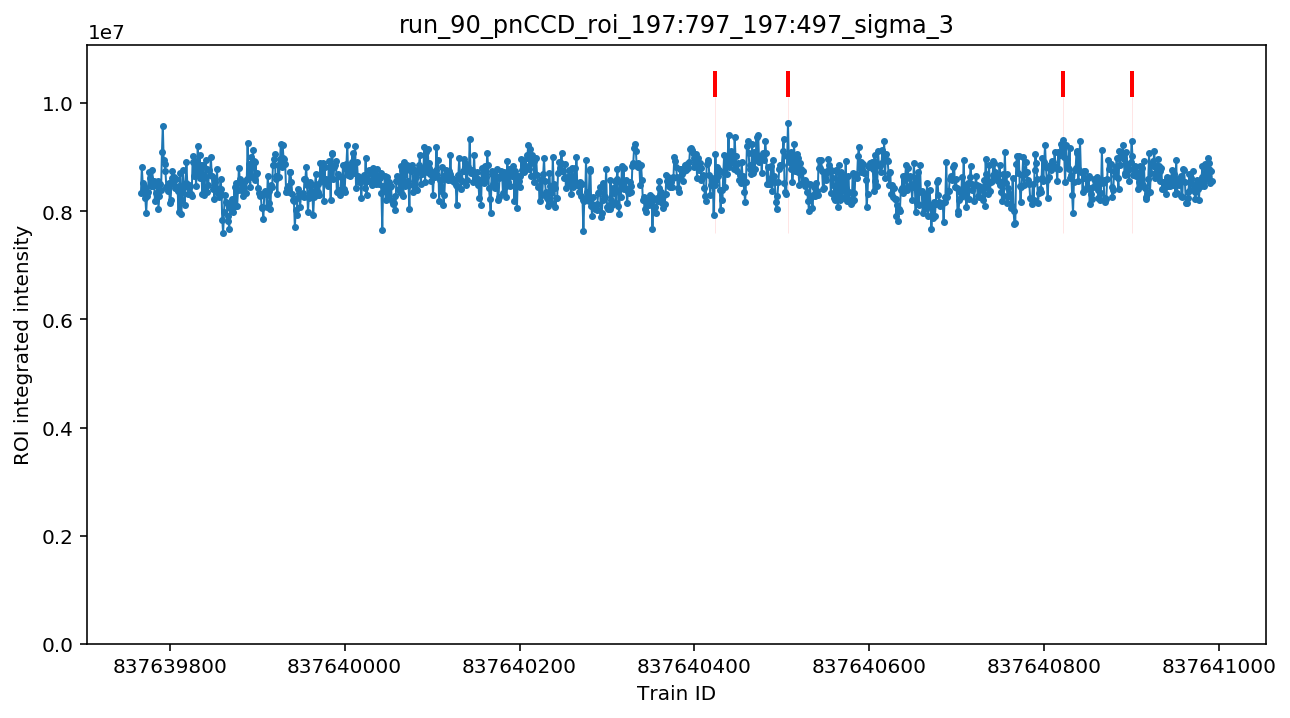

In [180]:
#pnccd_roi   (vertical, horizontal) pixels
pnccd_roi = (512-150-165,512+150-165+300, 512-150-165,512+150-165) # updated Aug28 to opposite corner for best detection

# Now finding hits by standard deviation above mean, threshold not needed. Also, can pick roi over stray light area as we normalize by xgm intensity
run_id = 90
sigma = 3
pnccd_cutoff = 20 if run_id < 133 else 60
# if you get a h5 error, try a lower pnccd cutoff of ~20

# Need to run filter_hits so that we save an HDF5 file
all_tids, hit_tids, itof_traces, pnccd_ims, pnccd_ints, xdata, xgm_intensities = filter_hits(run_id, 'out', pnccd_roi=np.s_[pnccd_roi[0]:pnccd_roi[1], pnccd_roi[2]:pnccd_roi[3]], sigma=sigma, pnccd_cutoff=pnccd_cutoff)

plot_intensity_all_images(all_tids, pnccd_ints, hit_tids, run_id, pnccd_roi, sigma, output_root, save=True)

run_90_norm_intensity_by_xgm.png STATS:  1226 1226 4
hit_tids:  [837640424 837640507 837640822 837640900]


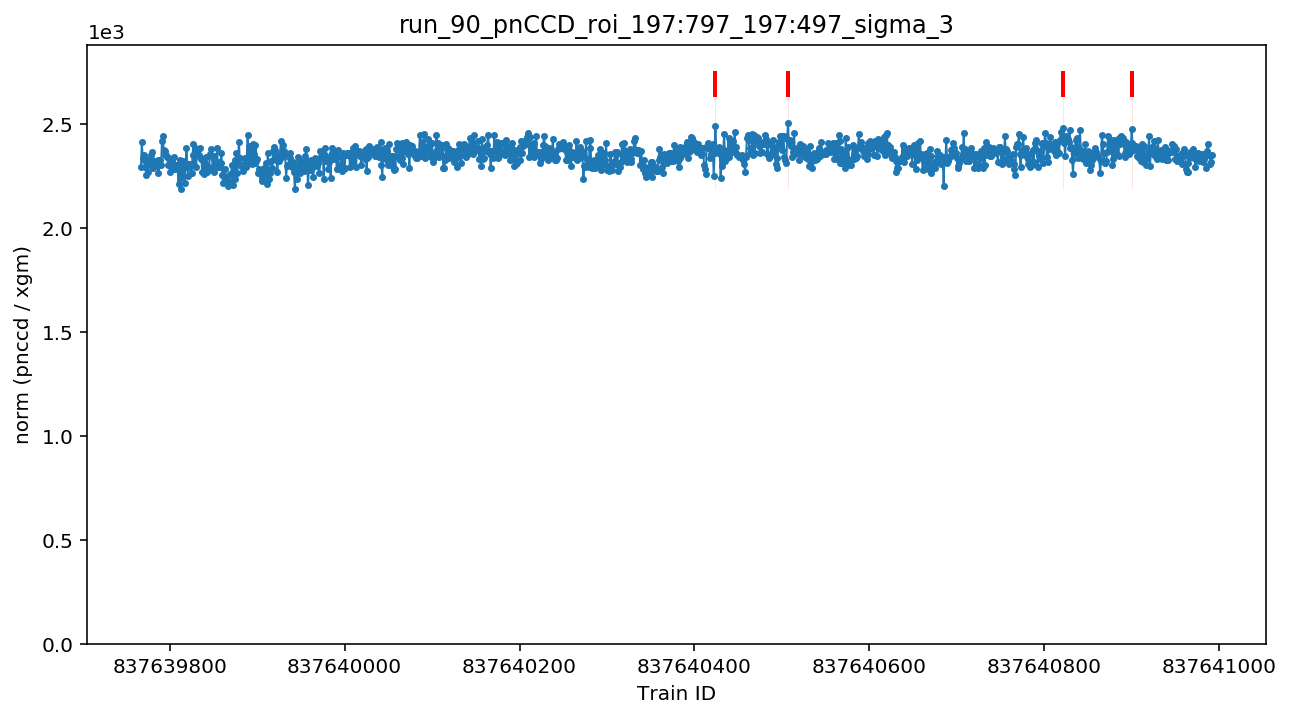

In [181]:
plot_intensity_all_images(all_tids, (pnccd_ints/xgm_intensities), hit_tids, run_id, pnccd_roi, 
                          sigma, output_root, ylabel='norm (pnccd / xgm)', save=True, filename='norm_intensity_by_xgm')

run_90_xgm_intensity.png STATS:  1226 1226 4
hit_tids:  [837640424 837640507 837640822 837640900]


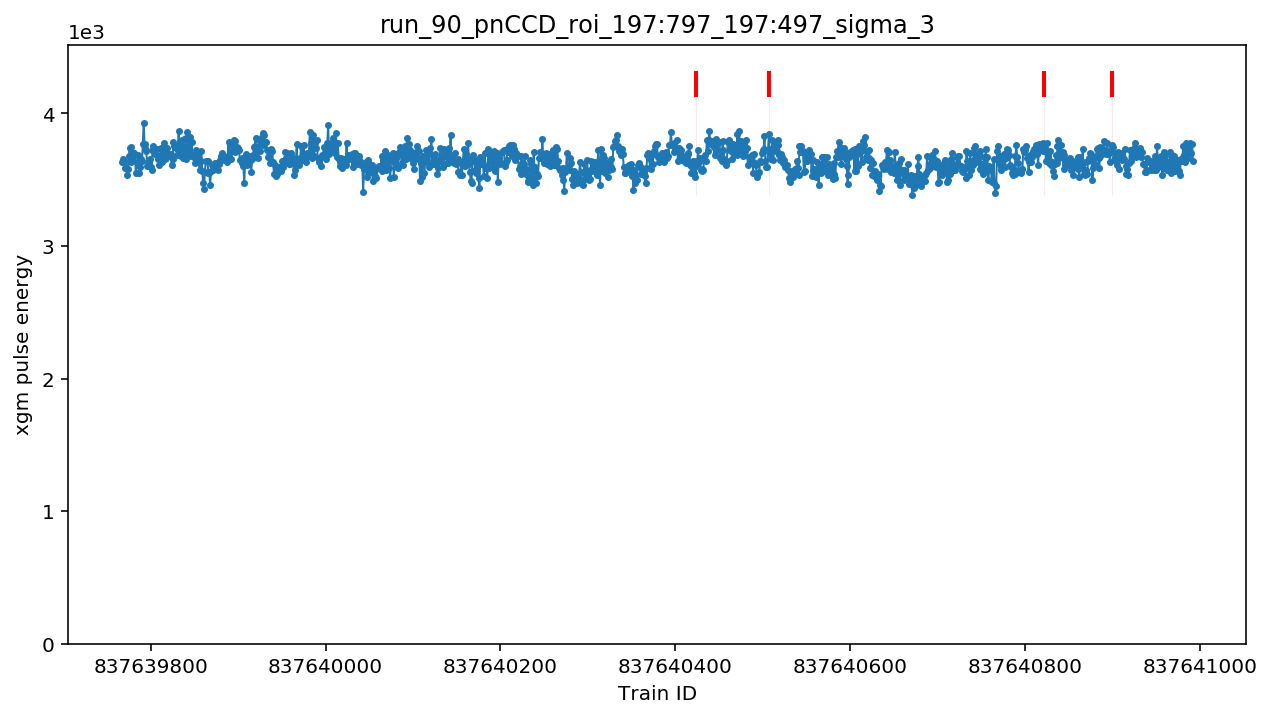

In [182]:
plot_intensity_all_images(all_tids, (xgm_intensities), hit_tids, run_id, pnccd_roi, 
                          sigma, output_root, ylabel='xgm pulse energy', save=True, filename='xgm_intensity')

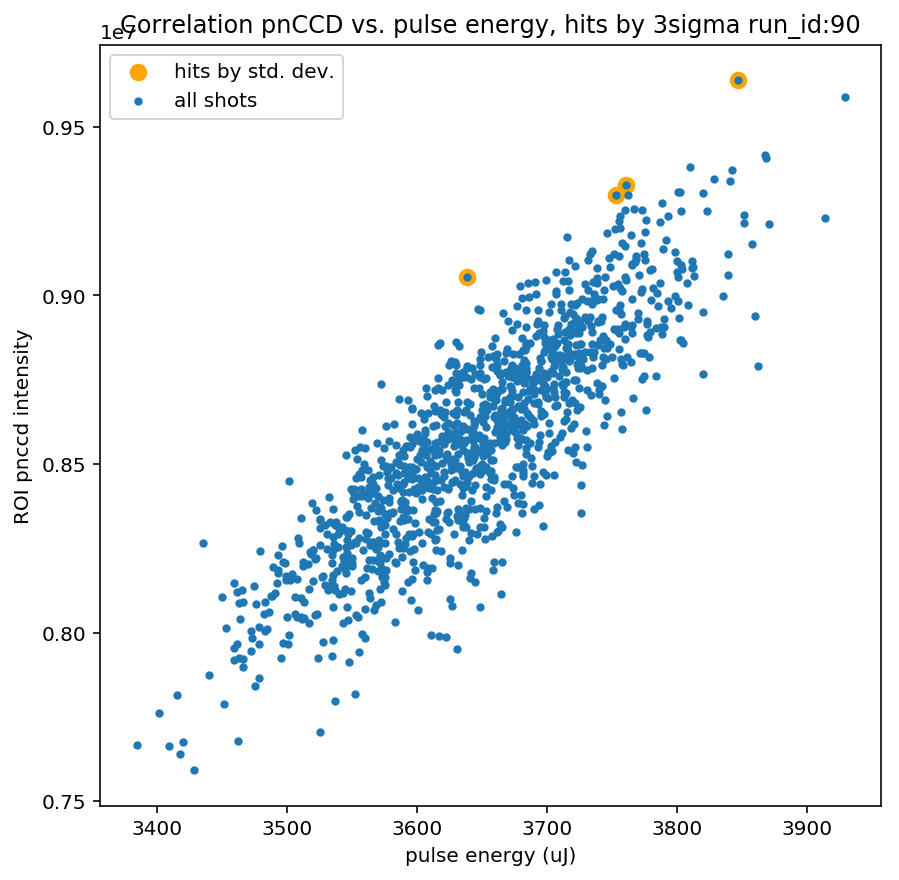

In [183]:
#Take extreme care to compare apples to apples and not oranges! Consider ROI
#xdata and hit_ints are hitfiltered
#xgm_intensities, pnccd_ints are unfiltered, one value for every image recorded

roi = np.s_[pnccd_roi[0]:pnccd_roi[1], pnccd_roi[2]:pnccd_roi[3]]
hit_ints = [(pnccd_im[roi]*(pnccd_im[roi] >=20)).sum() for pnccd_im in pnccd_ims]
hit_xgm =  [np.mean(x[x!=1]) for x in xdata['xgm'] ]

fig, axs = plt.subplots(num=1, clear=True, ncols=1, nrows=1, figsize=(7, 7))
axs.scatter(hit_xgm, hit_ints, s=60, c='orange', label='hits by std. dev.')
axs.scatter(xgm_intensities, pnccd_ints, s=10, label='all shots')
axs.set_xlabel('pulse energy (uJ)')
axs.set_ylabel('ROI pnccd intensity')
axs.set_title(f'Correlation pnCCD vs. pulse energy, hits by {sigma}sigma run_id:{run_id}')
axs.legend()
plt_str = f'run_{run_id}_correlation.png'
plt.savefig(output_root / plt_str, dpi=100)
plt.show()

## Plot & SAVE images of hits

In [ ]:
# Save png into folder named run_{run_id}
plot_save_images(run_id, pnccd_ims, hit_tids, xdata, save=True)
# Function may be slow, we are plotting many high resolution images. Set sensible threshold above or it will save many images!
plot_image_hits(pnccd_ims, hit_tids, save=True)

In [38]:
all_tids.shape

(5315,)

In [39]:
all_tids[xgm_intensities > 2000].shape

(5018,)

In [37]:
[xgm_intensities > 2000]

[array([ True,  True,  True, ..., False, False, False])]

In [54]:
for i in range(132, 140):
    
    print(pnccd_cutoff )

20
60
60
60
60
60
60
60


In [ ]:
# Need fname_path to be directory with h5 files for shift

start = 95
stop = 312

if (start > stop): 
    direction = -1  # if start > stop, direction should be -1 !!
else: 
    direction = 1

# Shift2 99-115, # Shift3 123-179, # Shift4 184-248, # Shift5 250+
# Need to go back and rerun 123-152

for i in range(start, stop+direction, direction):
    file = f"r{i}_out.h5"
    folder = f"run_000{i}"
    
    print(f"{file}: Starting analysis")
    #pfile = os.path.abspath(fname_path + file)

    #if os.path.isfile(pfile):
    #    print(f'             Working on {pfile}')
    #else:
    #    print(f"             WARNING: {file} not found")
    #    continue

    run_id = i
    
    # pnccd_cutoff = 20 for runs < 133, and =60 for runs > 133.
    pnccd_cutoff = 20 if run_id < 133 else 60
    
    try:
        try:
            all_tids, hit_tids, itof_traces, pnccd_ims, pnccd_ints, xdata, xgm_intensities = filter_hits(run_id, 'out', pnccd_roi=np.s_[pnccd_roi[0]:pnccd_roi[1], pnccd_roi[2]:pnccd_roi[3]], sigma=sigma, pnccd_cutoff=pnccd_cutoff)

        except:
            print(f"FAULT:\nFAULT:\nFAULT: unable to filter_hits() {file}\nFAULT:\n")
            pnccd_cutoff = 20
            print(f"RETRYING with lower pnccd_cutoff {pnccd_cutoff}")
            #Not sure why but  pnccd cutoff can cause h5 export crash
            all_tids, hit_tids, itof_traces, pnccd_ims, pnccd_ints, xdata, xgm_intensities = filter_hits(run_id, 'out', pnccd_roi=np.s_[pnccd_roi[0]:pnccd_roi[1], pnccd_roi[2]:pnccd_roi[3]], sigma=sigma, pnccd_cutoff=pnccd_cutoff)
    except: 
        print("File not found")
        
    try:
        plot_intensity_all_images(all_tids, pnccd_ints, hit_tids, run_id, pnccd_roi, sigma, output_root, save=True)
    except:
        print(f"FAULT:\nFAULT:\nFAULT: unable to plot pnccd_ints {file}\nFAULT:\n")

    try:
        plot_intensity_all_images(all_tids, (pnccd_ints/xgm_intensities), hit_tids, run_id, pnccd_roi, 
                              sigma, output_root, ylabel='norm (pnccd / xgm)', save=True, filename='norm_intensity_by_xgm')
    except:
        print(f"FAULT:\nFAULT:\nFAULT: unable to plot norm (pnccd / xgm) {file}\nFAULT:\n")
    
    try:
        #Take extreme care to compare apples to apples and not oranges! Consider ROI
        #xdata and hit_ints are hitfiltered
        #xgm_intensities, pnccd_ints are unfiltered, one value for every image recorded
        roi = np.s_[pnccd_roi[0]:pnccd_roi[1], pnccd_roi[2]:pnccd_roi[3]]
        hit_ints = [(pnccd_im[roi]*(pnccd_im[roi] >= pnccd_cutoff)).sum() for pnccd_im in pnccd_ims]
        hit_xgm =  [np.mean(x[x!=1]) for x in xdata['xgm'] ]

        fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(7, 7))
        axs.scatter(hit_xgm, hit_ints, s=60, c='orange', label='hits by std. dev.')
        axs.scatter(xgm_intensities, pnccd_ints, s=10, label='all shots')
        axs.set_xlabel('pulse energy (uJ)')
        axs.set_ylabel('ROI pnccd intensity')
        axs.set_title(f'Correlation pnCCD vs. pulse energy, hits by {sigma}sigma run_id:{run_id}')
        axs.legend()
        plt_str = f'run_{run_id}_correlation.png'
        plt.savefig(output_root / plt_str, dpi=100)
        plt.show()   
    except:
        print(f"FAULT:\nFAULT:\nFAULT: unable to histogram {file}\nFAULT:\n")
        
    
        
    

## TOF analysis per PULSE

In [19]:
run_id = 82

Found 98 (8.09%) hits out of 1212 trains in 1.63 s
n_pulses = 32 in run 82, does this look right?


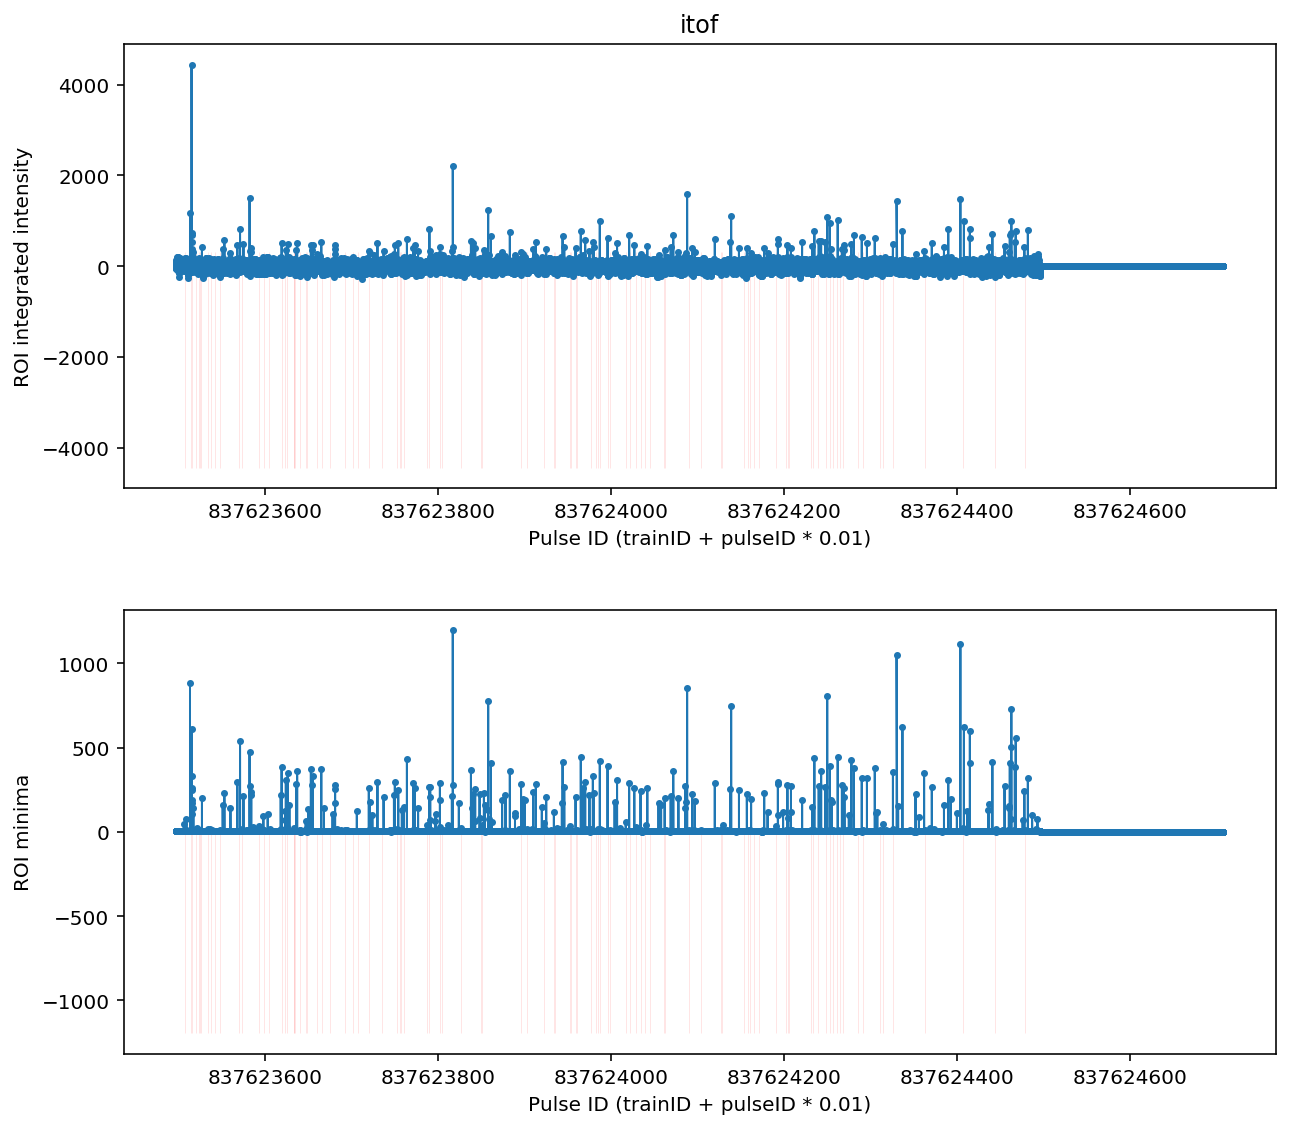

In [20]:
#Tested with run 82, itof_minima gives cleaner hit count
all_tids, itof_intensities, itof_minima, hit_tids, pulse_traces = get_itof_intensities(run_id, itof_roi=np.s_[520:650], itof_separation=1710)

n_pulses = len(itof_intensities) // len(all_tids)
print(f'n_pulses = {n_pulses} in run {run_id}, does this look right?')
pulse_ids = np.repeat(all_tids, n_pulses).astype(np.float64)

for i in range(n_pulses):
    pulse_ids[i::n_pulses] += i * 0.01

fig, (tx, bx) = plt.subplots(num=5, clear=True, ncols=1, nrows=2, figsize=(9, 8))
fig.tight_layout(rect=(0.03, 0.02, 1, 0.97), h_pad=4)

for ax, data in zip([tx, bx], [itof_intensities, itof_minima]):
    ax.plot(pulse_ids, data*-1, '.-', ms=5, lw=1)
    
    ax.set_xlabel('Pulse ID (trainID + pulseID * 0.01)')
    ax.ticklabel_format(axis='x', style='plain', useOffset=False)
    
    ax.vlines(hit_tids, data.max()*1.05, data.max()*1.1, linewidth=2, color='red')
    ax.vlines(hit_tids, data.min(), data.max()*1.05, alpha=0.1, linewidth=0.5, color='red')

tx.set_title('itof')
tx.set_ylabel('ROI integrated intensity')
bx.set_ylabel('ROI minima')
plt.show()

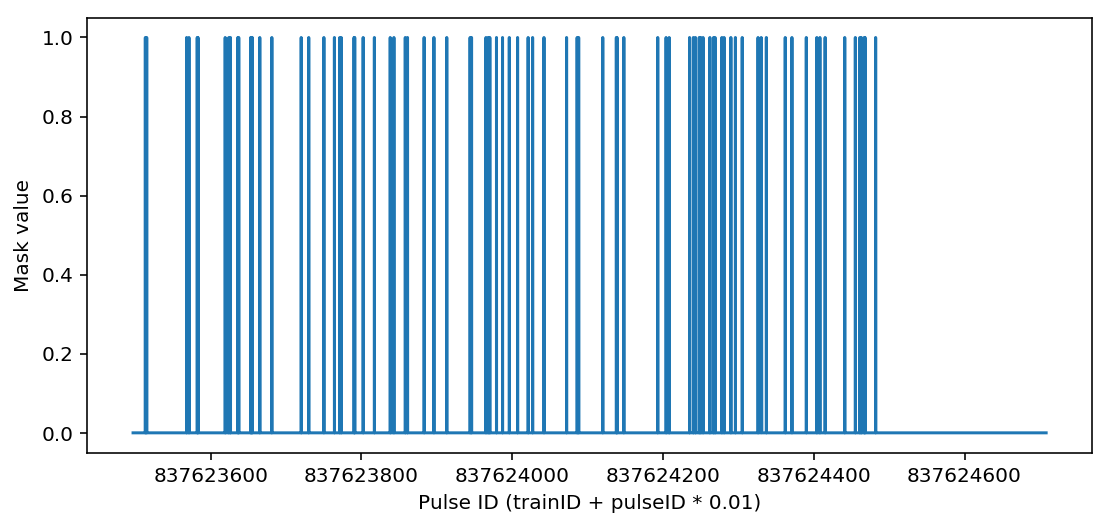

92 pulses hit using post-processing mask threshold 250


In [21]:
# Use a sensible threshold to pick out interesting TOFs
itof_thres = 250

itof_minima_mask = np.zeros_like(itof_minima)
itof_minima_mask[abs(itof_minima) > itof_thres] = 1

fig, ax = plt.subplots(num=15, clear=True, ncols=1, nrows=1, figsize=(9, 4))
ax.plot(pulse_ids, itof_minima_mask)
ax.set_xlabel('Pulse ID (trainID + pulseID * 0.01)')
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.set_ylabel('Mask value')
plt.show()

hit_pulse_traces = pulse_traces[itof_minima_mask.astype(bool)]
print(f'{hit_pulse_traces.shape[0]} pulses hit using post-processing mask threshold {itof_thres}')

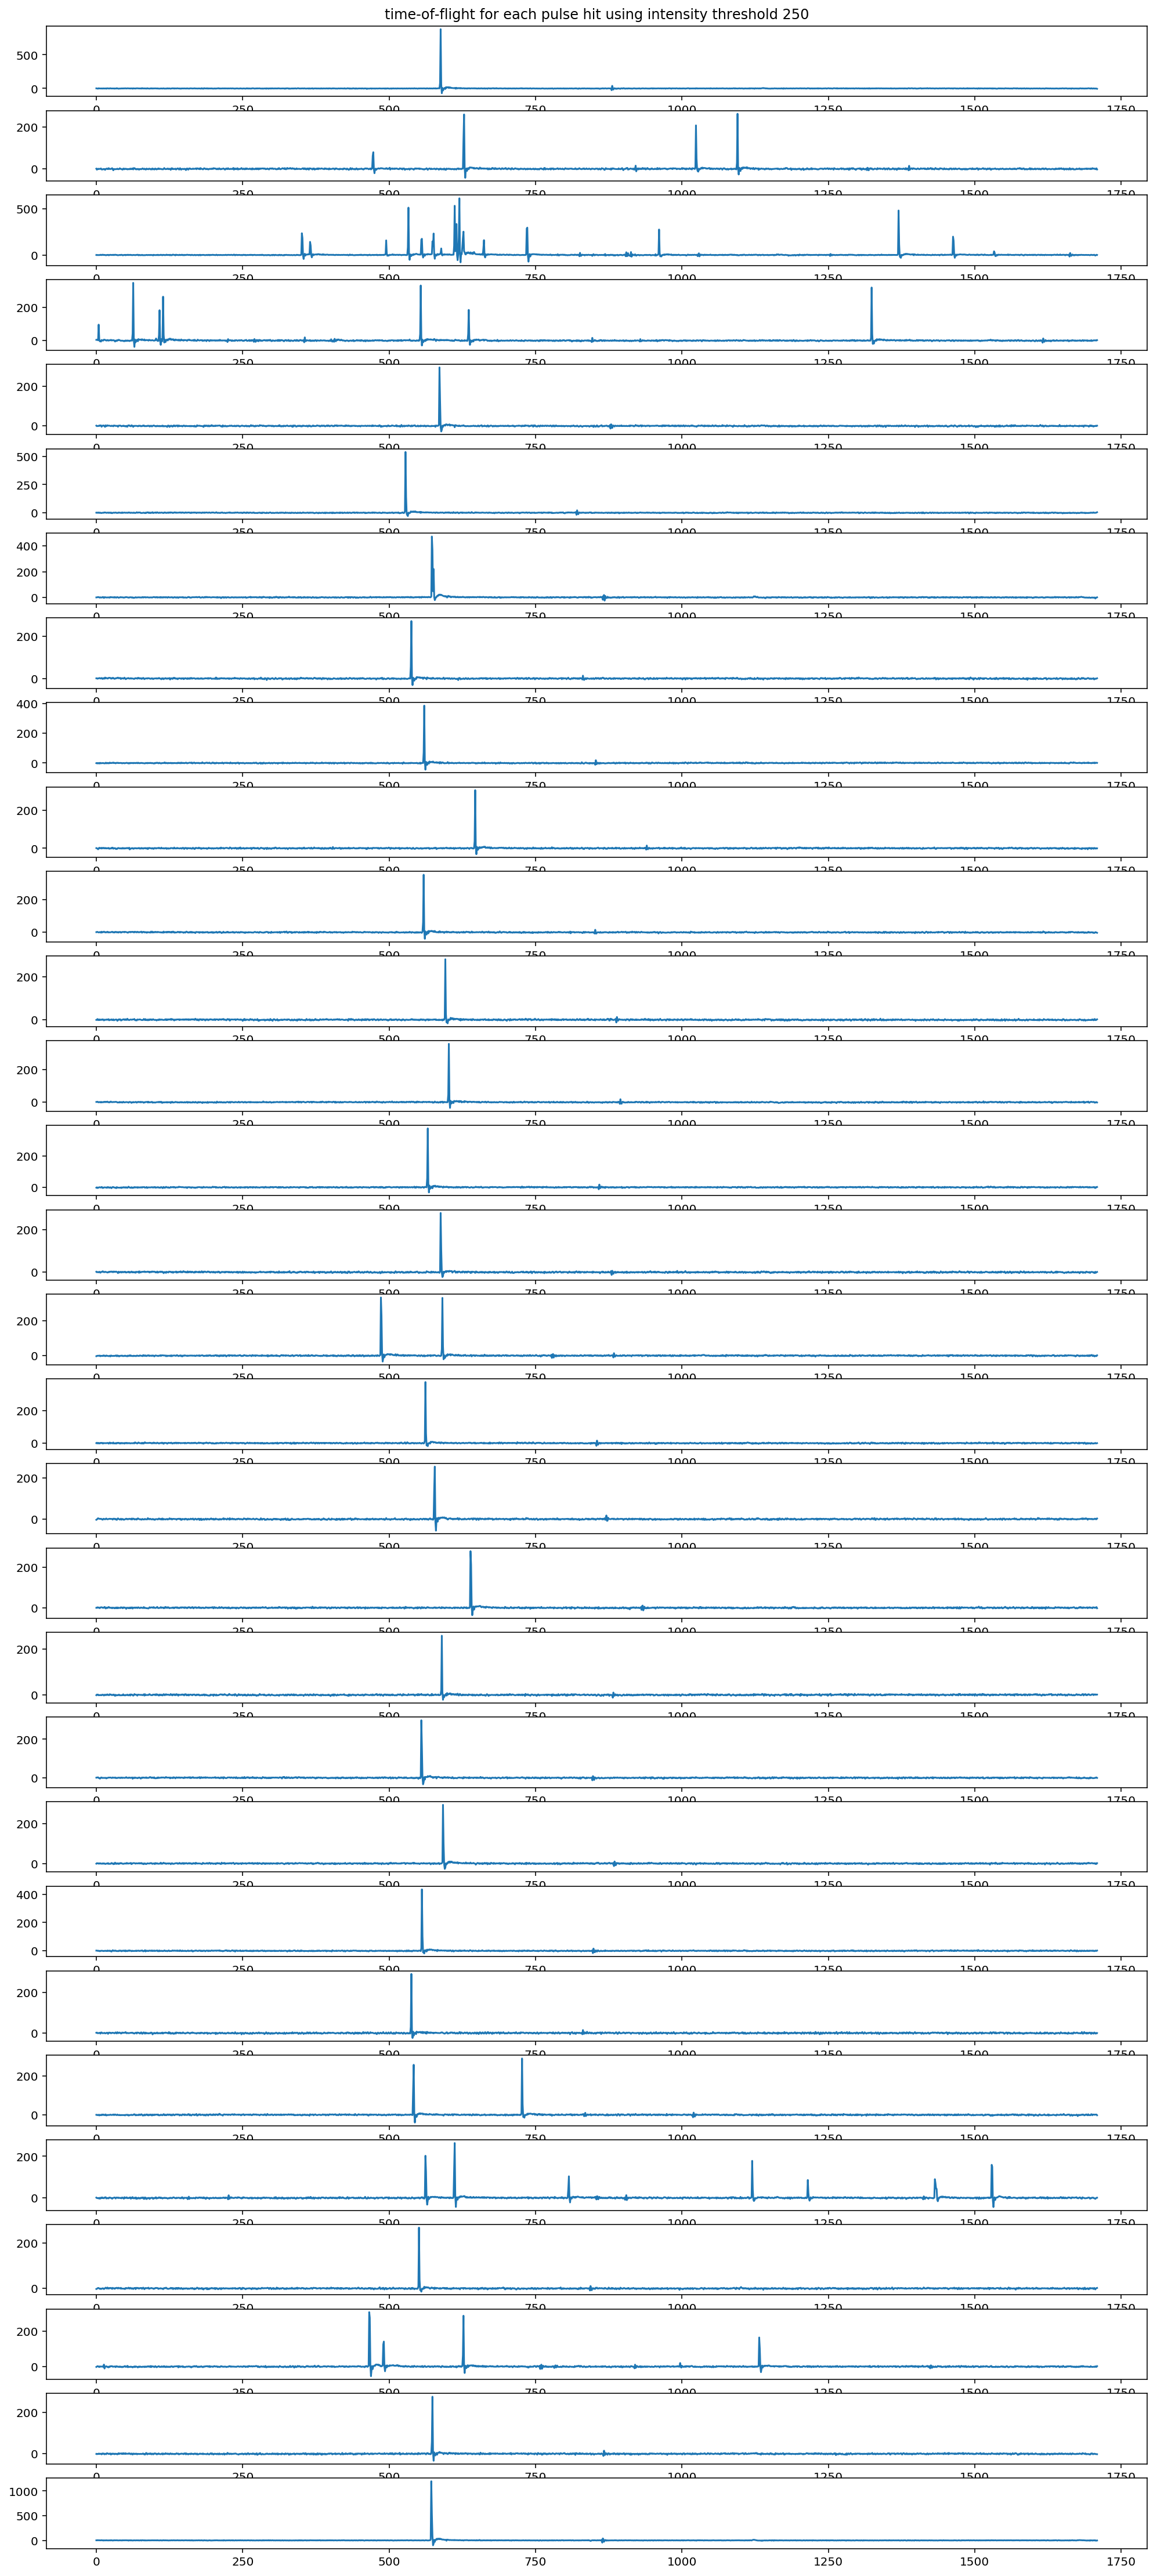

In [22]:
# Plot interesting TOFs and save
n_show = 30 # Can set this to a smaller number e.g. 10 or hit_pulse_traces.shape[0] to view all hits

n_rows = min(n_show, hit_pulse_traces.shape[0]) 
fig, ax = plt.subplots(num=9, clear=True, ncols=1, nrows=n_rows, figsize=(17, 40))
for i in range(n_rows):
    ax[i].plot(np.transpose(-1*hit_pulse_traces[i]))

ax[0].set_title(f'time-of-flight for each pulse hit using intensity threshold {itof_thres}')
plt.show()

plt_str = f'run_{run_id}_pulse_tof'
fig.savefig(output_root / plt_str)

## Old bits of code

In [24]:
#tids, itof_traces, pnccd_ims, xdata = filter_hits(28, '643am')

In [ ]:
fig, (lx, rx) = plt.subplots(num=1, clear=True, ncols=2, nrows=1, figsize=(9, 5))
fig.tight_layout(rect=(0, 0, 1, 0.97))

fig.text(0.5, 0.98, f'Train {tids[0]}', ha='center', va='top', size='large')
#lx.plot(itof_traces[0], lw=1)

lx.imshow(pnccd_ims[1][520:650, 350:490])
rx.imshow(pnccd_ims[0])
rx.add_patch(Rectangle((350, 520), 490-350, 650-520, fc='none', ec='red'))

## New method to use distribution of pnccd_intensities for run to find bright outliers (i.e. hits!)

In [105]:
# You MUST run the filter_hits() function first to load pnccd_ints with their associated all_tids

sigma = 4
hit_tids_by_sigma = all_tids[pnccd_ints > np.mean(pnccd_ints) + sigma*np.std(pnccd_ints)]

## Helper function to view images when you know hit_tids

In [10]:
def get_images_hits(run_id=run_id, trains_ids=np.s_[:], hit_tids=hit_tids):
    print(f'Hit ids: {hit_tids}')
    run = xd.open_run(proposal=proposal_id, run=run_id, data='proc') \
        .select_trains(trains_ids) \
        .select([(pnccd_source, pnccd_key)] + list(additional_data.values()))
    
    pnccd_shape = run[pnccd_source, pnccd_key].entry_shape
    pnccd_ims = xp.array((len(hit_tids), *pnccd_shape), dtype=np.float32)   
    print(pnccd_ims.shape)
    
           
    xshapes = {prefix: run[source, key].entry_shape
               for prefix, (source, key)
               in additional_data.items()}

    xdtypes = {prefix: run[source, key].dtype
               for prefix, (source, key)
               in additional_data.items()}
        
    xdata = {prefix: xp.array((len(hit_tids), *xshapes[prefix]), dtype=xdtypes[prefix]) for prefix in additional_data.keys()}   
    
    # Read the data for hits into memory.
    def read_hits(worker_id, index, train_id, data):
        try:
            pnccd_im = data[pnccd_source][pnccd_key]
            xargs = {prefix: data[source][key]
                     for prefix, (source, key)
                     in additional_data.items()}
        except (TypeError, KeyError):
            # Data may be missing for either source.
            return

        pnccd_im[np.isnan(pnccd_im)] = 0.0          
        pnccd_ims[index] = pnccd_im

        for prefix, xarg_data in xargs.items():
            xdata[prefix][index] = xarg_data    
 
 
    start = perf_counter()
    xp.map(read_hits, run.select_trains(xd.by_id[hit_tids]))
    end = perf_counter()
    
    print("Entire image sums:", [im.sum() for im in pnccd_ims])
    return pnccd_ims, xdata

In [60]:
pnccd_ims, xdata = get_images_hits(hit_tids = hit_tids_by_sigma)
plot_image_hits(pnccd_ims, hit_tids_by_sigma, save=False)

NameError: name 'hit_tids_by_sigma' is not defined

In [63]:
# export pnccd images

#run_id = 112
#hit_tids = np.array([837883848, 837884171, 837884512, 837884835, 837884927])
run_id = 154
hit_tids = np.array([838602790, 838607573, 838603447, 838603236, 838603253, 838603956, 838605737])

pnccd_ims, xdata = get_images_hits(run_id=run_id, hit_tids=hit_tids)

Hit ids: [838602790 838607573 838603447 838603236 838603253 838603956 838605737]
(7, 1024, 1024)
Entire image sums: [4013548.0, 4307853.0, 4329002.0, 4144224.0, 5127714.5, 6654103.0, 4096129.8]


In [ ]:
plot_save_images(run_id, pnccd_ims, hit_tids, xdata)